In [35]:
import ergo, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import urllib.request as urllib
from datetime import datetime, date
import pickle
import time
import warnings

plt.rcParams['figure.figsize'] = [3, 2]
warnings.filterwarnings('ignore')

def openfor(qdata):
    return (pd.to_datetime(qdata["close_time"])-pd.to_datetime(qdata["publish_time"])).days
def resolvedafter(qdata):
    return (pd.to_datetime(qdata["resolve_time"])-pd.to_datetime(qdata["publish_time"])).days
def closedfor(qdata):
    return (pd.to_datetime(qdata["resolve_time"])-pd.to_datetime(qdata["close_time"])).days
def sincepub(qdata):
    return (pd.Timestamp.today(tz="UTC")-pd.to_datetime(qdata["publish_time"])).days
def getq(n):
    with open('questions/q'+str(n)+'.p', 'rb') as fp:
        return pickle.load(fp)
def overconfidence(sample):
    num=0
    denom=0
    for pred in sample:
        num+=(pred-1)*(pred-.5)
        denom+=(pred-.5)*(pred-.5)
    return num/denom


def resolvetime(rtime):
    try: 
        return pd.to_datetime(datetime.strptime(rtime, '%Y-%m-%dT%H:%M:%SZ'))
    except :
        return pd.to_datetime(date(2100,1, 1))
    
def pofr(p,r):
    if r==0.:
        return 1-p
    elif r==1.:
        return p
    else:return None

    
def EBrier(pred):
    return pred*(1-pred)*(1-pred)+(1-pred)*pred*pred

In [3]:
print('Logging in to Metaculus...')
metaculus = ergo.Metaculus()
metaculus.login_via_username_and_password(username="", password="")
print('...Logged on')

Logging in to Metaculus...
...Logged on


## Pull questions from metaculus and store them in pickle files along with a question catalogue - 7.2 second delay after each question is to avoid Metaculus throttling which I think is 500qs/hr


In [140]:
# import ergo
# import pickle
# import time

# print('Logging in to Metaculus...')
# metaculus = ergo.Metaculus()
# metaculus.login_via_username_and_password(username='', password='')
# print('...Logged on')

# # grab every Q from metaculus by iterating over the potential QIDs and dump in pickle,
# # cataloguing the QIDs as dead, binary, or continuous - 7.2 second wait is due 
# # to metaculus API throttling of 500(?) per hour

# qiddict={}
# for i in range(7200):
#     time.sleep(7.2)
#     try:
#         q = metaculus.get_question(i)
#         qiddict[i]= q.data["possibilities"]["type"]
        

#         with open('questions/q'+str(i)+'.p', 'wb') as fp:
#             pickle.dump(q.data, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
#     except:
#         qiddict[i]= "dead"

# with open('questions/catalogue.p', 'wb') as fp:
#     pickle.dump(qiddict, fp, protocol=pickle.HIGHEST_PROTOCOL)
        

In [4]:

with open('questions/catalogue.p', 'rb') as fp:
    qiddict=pickle.load(fp)

In [5]:
qtypes=pd.Series(qiddict)

In [6]:
qtypes.value_counts()

dead          4453
binary        1497
continuous    1250
dtype: int64

In [7]:
binarycodes=list(qtypes[qtypes.values=="binary"].index)

In [8]:
len(binarycodes)

1497

## Load Qs from pickle files and make dataframe of predictions

In [10]:

qs={}
for q in binarycodes:
    with open('questions/q'+str(q)+'.p', 'rb') as fp:
        qs[q] = pickle.load(fp)

In [11]:
qvariances=dict()
for i in binarycodes:
    variances=[]
    for sample in qs[i]["prediction_timeseries"]:
        variances.append(sample["distribution"]["var"])
    qvariances[i]=variances
qmeans=dict()
for i in binarycodes:
    means=[]
    for sample in qs[i]["prediction_timeseries"]:
        means.append(sample["distribution"]["avg"])
    qmeans[i]=means
qmedians=dict()
qfinals=dict()
for i in binarycodes:
    medians=[]
    for sample in qs[i]["prediction_timeseries"]:
        medians.append(sample["community_prediction"])
        last=sample["community_prediction"]
    qmedians[i]=medians
    qfinals[i]=[last]*len(medians)
qpredcount=dict()
for i in binarycodes:
    predcount=[]
    for sample in qs[i]["prediction_timeseries"]:
        predcount.append(sample["num_predictions"])
    qpredcount[i]=predcount
qtimes=dict()
rtimes=dict()
for i in binarycodes:
    times=[]
    for sample in qs[i]["prediction_timeseries"]:
        times.append(sample["t"])
    qtimes[i]=times


In [12]:
frames=dict()
for i in binarycodes:
    frames[i]=pd.DataFrame([qtimes[i],qvariances[i],qmeans[i],qmedians[i],qpredcount[i],qfinals[i]]).T
    frames[i].columns=["Time", "Variance", "Mean", "Median", "Count", "Final"]
    frames[i]["Time"]=frames[i]["Time"].apply(lambda t: datetime.fromtimestamp(t))
    frames[i]["QID"]=i
    frames[i]["Resolve_Time"]=qs[i]["resolve_time"]
    frames[i]["Resolution"]=qs[i]["resolution"]

In [73]:

#with open('questions/questiondfs.p', 'wb') as fp:
#    pickle.dump(frames,fp)

In [13]:
allqs=pd.concat(frames)

In [15]:
allqs.Resolution.unique()

array([ 0., -1.,  1., nan])

In [16]:
allqs.shape

(130606, 9)

In [17]:
allqs=allqs[allqs.Resolution!=-1.]

In [26]:
allqs.head()

Time  Variance  Mean  Median  Count  Final  QID  \
1 0 2015-10-02 03:36:23.463465    0.0000  0.69    0.69    1.0   0.65    1   
  1 2015-11-03 21:35:14.195666    0.0009  0.72    0.75    2.0   0.65    1   
  2 2015-11-03 21:36:25.264527    0.0000  0.75    0.75    3.0   0.65    1   
  3 2015-11-04 02:19:20.937501    0.0882  0.54    0.75    4.0   0.65    1   
  4 2015-11-04 02:19:27.131253    0.0882  0.54    0.75    5.0   0.65    1   

           Resolve_Time  Resolution                  horizon  
1 0 2016-02-01 03:34:00         0.0 121 days 23:57:36.536535  
  1 2016-02-01 03:34:00         0.0  89 days 05:58:45.804334  
  2 2016-02-01 03:34:00         0.0  89 days 05:57:34.735473  
  3 2016-02-01 03:34:00         0.0  89 days 01:14:39.062499  
  4 2016-02-01 03:34:00         0.0  89 days 01:14:32.868747

In [24]:
allqs.Resolve_Time=allqs.Resolve_Time.apply(lambda x: resolvetime(x))

## Get question time horizons, get Brier scores, confidence etc, then produce calibration graphs

In [25]:
allqs["horizon"]=allqs.Resolve_Time-allqs.Time

In [30]:
allqs["Brier"]=(allqs["Resolution"]-allqs["Median"])*(allqs["Resolution"]-allqs["Median"])
allqs["OutcomeP"]=allqs[["Median", "Resolution"]].apply(lambda x:  pofr(*x), axis=1)
allqs["EBrier"]=allqs.Median.apply(lambda x: EBrier(x))

(45844, 13)
0.15170444775558786
0.1728197102194538
-0.286750424699701
0.16744864160189582
0.1931986406950318
-0.32997907789910763
0.1689777584822764
0.19237486898700282
-0.30963635685223845


<AxesSubplot:title={'center':'Samples'}, xlabel='Predicted Frequency', ylabel='Count'>

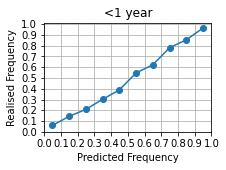

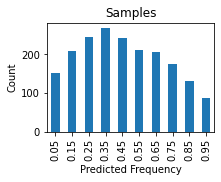

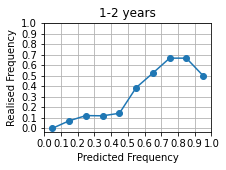

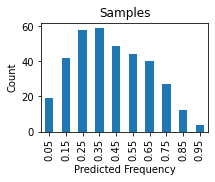

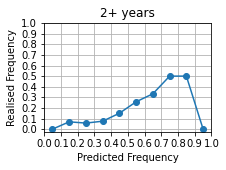

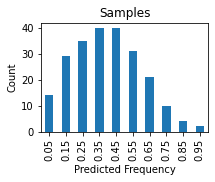

In [39]:
l,k=1,0
resqs=allqs[allqs.Resolution.apply(lambda x: x in [0.,1.])][allqs.horizon<pd.Timedelta(days=365*l)][allqs.horizon>pd.Timedelta(days=365*k)]
resqs=resqs[resqs.Count>2.5]
calibrations=dict()
samplesize=dict()
print(resqs.shape)
print(np.mean(resqs.groupby("QID").mean().Brier))
print(np.mean(resqs.groupby("QID").mean().EBrier))
print(overconfidence(resqs.groupby("QID").mean().OutcomeP))
for i in range(10):
    samplesize[round(i/10.0+.05,2)]=resqs[resqs.Median<((i+1.0)/10.0)][resqs.Median>(i/10.0)].groupby("QID").mean().shape[0]
    calibrations[round(i/10.0+.05,2)]=np.mean(resqs[resqs.Median<((i+1.0)/10.0)][resqs.Median>(i/10.0)].groupby("QID").mean().Resolution)
pd.DataFrame.from_dict(calibrations, orient="index").plot(title="<1 year",grid=True,marker='o', xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],yticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],xlabel ="Predicted Frequency",ylabel ="Realised Frequency", legend=False)
pd.DataFrame.from_dict(samplesize, orient="index").plot(title="Samples",kind="bar",xlabel ="Predicted Frequency",ylabel ="Count", legend=False)

l,k=2,1
resqs=allqs[allqs.Resolution.apply(lambda x: x in [0.,1.])][allqs.horizon<pd.Timedelta(days=365*l)][allqs.horizon>pd.Timedelta(days=365*k)]
resqs=resqs[resqs.Count>2.5]
calibrations=dict()
samplesize=dict()

print(np.mean(resqs.groupby("QID").mean().Brier))
print(np.mean(resqs.groupby("QID").mean().EBrier))

print(overconfidence(resqs.groupby("QID").mean().OutcomeP))
for i in range(10):
    samplesize[round(i/10.0+.05,2)]=resqs[resqs.Median<((i+1.0)/10.0)][resqs.Median>(i/10.0)].groupby("QID").mean().shape[0]
    calibrations[round(i/10.0+.05,2)]=np.mean(resqs[resqs.Median<((i+1.0)/10.0)][resqs.Median>(i/10.0)].groupby("QID").mean().Resolution)
pd.DataFrame.from_dict(calibrations, orient="index").plot(title="1-2 years",grid=True,marker='o', xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],yticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],xlabel ="Predicted Frequency",ylabel ="Realised Frequency", legend=False)
pd.DataFrame.from_dict(samplesize, orient="index").plot(title="Samples",kind="bar",xlabel ="Predicted Frequency",ylabel ="Count", legend=False)

l,k=5,2
resqs=allqs[allqs.Resolution.apply(lambda x: x in [0.,1.])][allqs.horizon<pd.Timedelta(days=365*l)][allqs.horizon>pd.Timedelta(days=365*k)]
resqs=resqs[resqs.Count>2.5]
calibrations=dict()
print(np.mean(resqs.groupby("QID").mean().Brier))
print(np.mean(resqs.groupby("QID").mean().EBrier))

print(overconfidence(resqs.groupby("QID").mean().OutcomeP))
samplesize=dict()

for i in range(10):
    df=resqs[resqs.Median<((i+1.0)/10.0)][resqs.Median>(i/10.0)].groupby("QID").mean()
    samplesize[round(i/10.0+.05,2)]=df.shape[0]
    calibrations[round(i/10.0+.05,2)]=np.mean(df.Resolution)
pd.DataFrame.from_dict(calibrations, orient="index").plot(title="2+ years",grid=True,marker='o', xticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],yticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],xlabel ="Predicted Frequency",ylabel ="Realised Frequency", legend=False)
pd.DataFrame.from_dict(samplesize, orient="index").plot(title="Samples",kind="bar", align='center',xlabel ="Predicted Frequency",ylabel ="Count", legend=False)